In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Numerical Integration

This lab helped me understand different and powerful forms of numerical integration. In the first part I had to develop my own method of numerical integration. This method had to have a $O(h^8)$ conversion order. The next section used my previous method of numerical integration but was adaptive in the sense that it could quickly find the number of nodes needed for a given tolerance. Finally, I applied my numerical integration process to hardening steel and calculating the carbon concentration relative to iron based on time and temperature.

## High-order numberical integration

#### Numerical integration methods

I tried two methods for achieving the desired $O(h^8)$ numerical integration function for approximating $$\int_{a}^{b} f(x)dx$$


These methods were implemented in a c++ file named *composite_int* with a method signature of 
```cpp
double composite_int(Fnc& f, const double a, const double b, const int n);
```

##### Rombergs
This method used recursive trapezoid method. Each iteration better models the function in question. This method achieved a conversion order of $\gt O(h^8)$ after 16 nodes. However, anything above $\approx$ 25 nodes resulted in a long computation time and the error was poor compared to the sample 2-node Gaussian method. Because of the high error, this method was scraped.

##### Four-Node Gaussian Quadrature
The second method I implemented was a Gaussian Quadrature with 4 Gaussian nodes and weights. This method achieved the desired $O(h^8)$ conversion order and had very acceptable error values that rapidly decreased as more nodes were used. 


$$i = \{1, 2, 3, 4\}$$


$$-\sqrt{ \frac{1}{7} (3-4 \sqrt{0.3})}, -\sqrt{ \frac{1}{7} (3+4 \sqrt{0.3})}, +\sqrt{ \frac{1}{7} (3-4 \sqrt{0.3})}, +\sqrt{ \frac{1}{7} (3+4 \sqrt{0.3})}$$


$$\frac{1}{2} + \frac{1}{12} \sqrt{ \frac{10}{3}}, \frac{1}{2} - \frac{1}{12} \sqrt{ \frac{10}{3}}, \frac{1}{2} + \frac{1}{12} \sqrt{ \frac{10}{3}}, \frac{1}{2} - \frac{1}{12} \sqrt{ \frac{10}{3}}$$ 


These nodes and weights were used to approximate the integral F of $$F = A_1 \times f(x_1) + A_2 \times f(x_2) + A_3 \times f(x_3) + A_4 \times f(x_4)$$ At each node $n_i$ where $x_i = n_i + 0.5\times h \times$ "node" $_i$


#### Testing my methods

After I developed the method to achieve both the $O(h^8)$ requirement and be sufficiently accurate I had to test my function. The function that my method was tested on is $$f(x) = e^{0.5x} + \sin (25x)$$ To test my function I run my method on $f(x)$ over the interval $[-3, 5]$ using nodes $$n=\{10, 15, 20, 30, 40, 50, 60, 80, 100, 120, 200, 250, 300, 400\}$$ The output from my composite test class is as follows

In [2]:
compFile = open("int.txt").read()
print(compFile)


 True Integral = 2.3924089071413306e+01

 Gauss-2 approximation:
     n             R(f)            relerr    conv rate
  ---------------------------------------------------
       10  2.4004419883352980e+01  3.4e-03     ----
       15  2.3907259400305129e+01  7.0e-04   3.854856
       20  2.3924921763522665e+01  3.5e-05   10.449851
       30  2.3924244960141589e+01  6.5e-06   4.132344
       40  2.3924084859071016e+01  1.8e-07   12.552481
       50  2.3924088677801649e+01  1.6e-08   10.622800
       60  2.3924088999577528e+01  3.0e-09   9.329572
       80  2.3924089065582592e+01  2.4e-10   8.729231
      100  2.3924089070518363e+01  3.7e-11   8.398786
      120  2.3924089071214624e+01  8.3e-12   8.254945
      200  2.3924089071410187e+01  1.3e-13   8.132134
      250  2.3924089071412791e+01  2.2e-14   8.070647
      300  2.3924089071413189e+01  4.9e-15   8.118767
      400  2.3924089071413309e+01  1.5e-16   12.154068
  ---------------------------------------------------



## Adaptive Numerical Integration

#### Adaptive Function

The purpose of my adaptive function is to calculate my integration approximation to a required tolerance without doing too much work. To achieve this I used my previous integration method with various values for n. My goal is to satisfy 


$$|I(f) - R_n(f)| < rtol |I(f)| + atol$$



However, because we do not know the actual integral $I(f)$ I must modify the inequality some. Because of the rapidly convergent integration method I created, I can exchange $I(f)$ with $R_{n+k}(f)$ with $k$ being some value I define. This result in the inequality 


$$|R_{n+k}(f) - R_n(f)| < rtol |R_{n+k}(f)| + atol$$


##### How I defined k

I defined k as a exponential function because in my test above in *test_composite.cpp* I saw that for lower levels of error bigger and bigger jumps were needed for each node. I defined my k values as 

$$k(x) = e^{0.4x + 0.4}$$ 

rounded to the nearest integer. Also, instead of adding k to my number of nodes I multiplied it. The first iteration started at $n=10$ being $R_n(x)$ and $R_{n*k(i)}(x)$ with i being the number of current runs


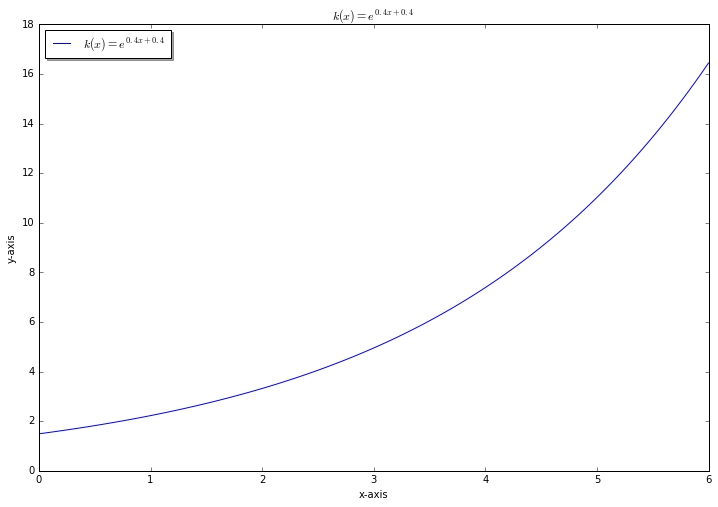

In [5]:
x = linspace(0,6,100)
y = 2.71828 ** (0.4*x + 0.4)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

ax.plot(x,y,"b-", label="$k(x)=e^{0.4x + 0.4}$")
ax.set_title("$k(x)=e^{0.4x + 0.4}$")
ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")

legendPlot1 = ax.legend(loc="upper left", shadow=True)

plt.show()

My adaptive method is defined in the c++ file *adaptive_int.cpp* with the method signature 
```cpp
int adaptive_int(Fcn& f, const double a, counst double b, const double rtol, const double atol, double& R, int & n, int& Ntot);
```

This function returns a 0 if successful and a 1 if failed. The values of $I(f)$ approximated, the number of nodes, and the different number of nodes tired are stored in R, n, Ntot respectfully.


#### Testing my Adaptive Method

To test my Adaptive method for validity, I created the c++ file *test_adapt.cpp*. In this file I ran my **adaptive_int()** function on the same function as my *test_Composite.cpp* function. However, this time I used every pair of $(rtol,atol)$ with $atol_i = \frac{rtol_i}{1000}$ and 


$$rtol=\{10^{-2},10^{-4},10^{-6},10^{-8},10^{-10},10^{-12}$$


The results of my adaptive tests are


In [6]:
adaptFile = open("adapt.txt").read()
print(adaptFile)


 True Integral = 2.3924089071413306e+01

 Adaptive Method approximation:
     n(nTol),   rtol           R(f)                |I(f) - R(f)|          rtol|I(f)| + atol
  -------------------------------------------------------------------------------------------
     10(  1), 1.0e-02  2.3924921763522665e+01  8.3269210935910110e-04  2.3925089071413308e-01
     20(  2), 1.0e-04  2.3924244960141589e+01  1.5588872828331546e-04  2.3925089071413306e-03
     50(  4), 1.0e-06  2.3924089053040777e+01  1.8372528387544662e-08  2.3925089071413303e-05
     70(  5), 1.0e-08  2.3924089071006748e+01  4.0655834254721412e-10  2.3925089071413308e-07
    110(  6), 1.0e-10  2.3924089071394292e+01  1.9014123608940281e-11  2.3925089071413307e-09
    160(  7), 1.0e-12  2.3924089071412791e+01  5.1514348342607263e-13  2.3925089071413304e-11
  -------------------------------------------------------------------------------------------



##### Analisys of my Adaptive Method

After some testing and multiple variants of $k(x)$ I arrived at the function I am currently using


$$k(x) = e^{0.4x + 0.4}$$ 


because at nearly every iteration of my run count, I double the precision of 


$$|I(f) - R(f)|$$


This allows for very quick analysis of the approximated integral $R(f)$ and with $rtol=10^{-12}$ my function only evaluated 160 nodes.


## Application

The final portion of this project required me to implement my previous methods in the context of hardening steel. Carbon concentration $C(x,t,T)$ at distance $x$ (in meters) from the surface, at time $t$ (in seconds), for a specified temperature T (in Kelvin) is 


$$C(x,t,T) = C_s - (C_s - C_0) erf(\frac{x}{\sqrt{4t D(R)}})$$


$C_0$ is the initial carbon concentration. $C_s$ is the gas' carbon concentration. $D(T) is the temperature-dependent diffusion of the steel.


$$D(T) = 6.2 \times 10^{-7}exp(\frac{8 \times 10^4}{8.31T})$$


Finally, the $erf$ function defined as


$$erf(y)= \frac{2}{\sqrt{\pi}}\int_{0}^{y}e^{-z^2}dz$$


To implement this complex formula, I defined two methods in the c++ file *carbon.cpp*
```cpp
double erf(const double y, const double rtol, const double atol);

double carbon(const doublex, const double t, const double T, const double rtol, const double atol);
```


#### Calculating Carbon Diffusion

To calculate the carbon diffusion at different temperatures I created a test program called *test_carbon.cpp* to perform the following tasks:

>Create an array of 400 evenly-spaced T values over the interval $[800, 1200]$ K.
>
Create an array of 600 evenly-spaced $t$ values from $t = 1$ second up to $t = 48$ hours.
>
Create a $400 \times 600$ array that contains $C(0.002, t, T)$.
>
Create a $400 \times 600$ array that contains $C(0.004, t, T)$.
>
Create an array of length 600 containing $C(0.002, t, 800)$. Repeat this to output the carbon concentrations for a 2 mm depth at
900K, 1000K, 1100K and 1200K.
>
Create an array of length 600 containing $C(0.004, t, 800)$. Repeat this to output the carbon concentrations for a 4 mm depth at
900K, 1000K, 1100K and 1200K.

All results were computed to a tolerance of $rtol = 10^{-11}$ and $atol = 10^{-15}$


#### Results

In [16]:
T = loadtxt("Temp.txt")
t = loadtxt("time.txt")

C2mm = loadtxt("C2mm.txt")
C4mm = loadtxt("C4mm.txt")

C2mm_800k = loadtxt("C2mm_800K.txt")
C2mm_900k = loadtxt("C2mm_900K.txt")
C2mm_1000k = loadtxt("C2mm_1000K.txt")
C2mm_1100k = loadtxt("C2mm_1100K.txt")
C2mm_1200k = loadtxt("C2mm_1200K.txt")

C4mm_800k = loadtxt("C4mm_800K.txt")
C4mm_900k = loadtxt("C4mm_900K.txt")
C4mm_1000k = loadtxt("C4mm_1000K.txt")
C4mm_1100k = loadtxt("C4mm_1100K.txt")
C4mm_1200k = loadtxt("C4mm_1200K.txt")

##### Contour plot of $C(0.002,t,T)$

([<matplotlib.axis.XTick at 0x7f12e22425f8>,
 <a list of 7 Text xticklabel objects>)

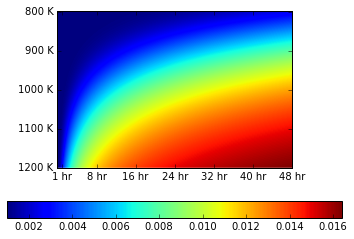

In [25]:
figure()
imshow(C2mm)
colorbar(orientation='horizontal')

yticks( (0, 100, 200, 300, 400,),
('800 K', '900 K', '1000 K', '1100 K', '1200 K'))
xticks( (12, 100, 200, 300, 400, 500, 600),
('1 hr', '8 hr', '16 hr', '24 hr', '32 hr', '40 hr', '48 hr'))

##### Analysis at 2mm depth
This graph shows us how both time (y-axis) and temperature (x-axis) effect how much carbon is diffused into the steel. It is clear however that temperature plays a greater roll in carbon diffusion then time because higher temperatures absorb more carbon quicker than lower temperatures. We can also tell that the rate of absorption is relatively quick compared to at $0.004$ meters in the next graph.


##### Contour plot of $C(0.004,t,T)$

([<matplotlib.axis.XTick at 0x7f12e23620f0>,
 <a list of 7 Text xticklabel objects>)

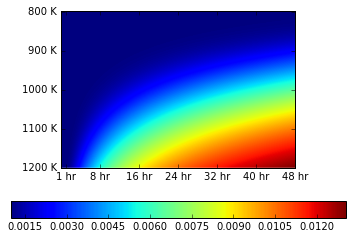

In [24]:
figure()
imshow(C4mm)
colorbar(orientation='horizontal')
yticks( (0, 100, 200, 300, 400,),
('800 K', '900 K', '1000 K', '1100 K', '1200 K'))
xticks( (12, 100, 200, 300, 400, 500, 600),
('1 hr', '8 hr', '16 hr', '24 hr', '32 hr', '40 hr', '48 hr'))

##### Analysis of 4mm depth
Like the graph above, the absorption of carbon is based on both time (y-axis) and temperature (x-azis) still favoring temperature. However, unlike the previous graph, absorption values are smaller and temperature must be much hotter $(\approx 100K)$ more for any absorption to take place


##### Absorption values at 2mm

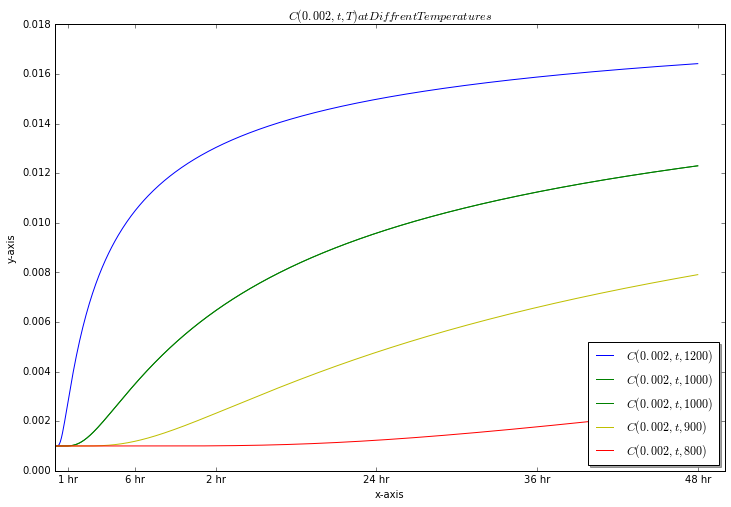

In [26]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

ax.plot(t,C2mm_1200k,"b-", label="$C(0.002,t,1200)$")
ax.plot(t,C2mm_1000k,"g-", label="$C(0.002,t,1000)$")
ax.plot(t,C2mm_1000k,"g-", label="$C(0.002,t,1000)$")
ax.plot(t,C2mm_900k,"y-", label="$C(0.002,t,900)$")
ax.plot(t,C2mm_800k,"r-", label="$C(0.002,t,800)$")

ax.set_title("$C(0.002,t,T) at Diffrent Temperatures$")
ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")

xticks( (1*3600, 6*3600, 12*3600, 24*3600, 36*3600, 48*3600),
('1 hr', '6 hr', '2 hr', '24 hr', '36 hr', '48 hr') )

legendPlot1 = ax.legend(loc="lower right", shadow=True)

plt.show()

##### Absorption by temperature at 2mm
This graph shows different levels of diffusion at different temperatures 


$$T =\{800K, 900K, 1000K, 1100K, 1200K\}$$


Temperature heavily effects carbon absorption. The blue line (1200 K) has a rapid spike around 1 hr. However, all graphs seem to approach about the same rate after $\approx$ 48 hr's. This lead me to conclude that temperature effects the rate of diffusion until a saturation point (for that temperature) is reach at which point diffusion stops.


##### Absorption values at 4mm

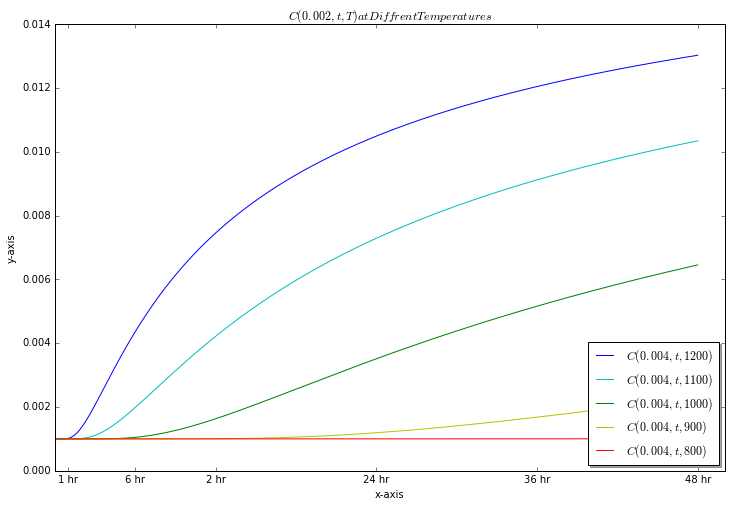

In [27]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

ax.plot(t,C4mm_1200k,"b-", label="$C(0.004,t,1200)$")
ax.plot(t,C4mm_1100k,"c-", label="$C(0.004,t,1100)$")
ax.plot(t,C4mm_1000k,"g-", label="$C(0.004,t,1000)$")
ax.plot(t,C4mm_900k,"y-", label="$C(0.004,t,900)$")
ax.plot(t,C4mm_800k,"r-", label="$C(0.004,t,800)$")

ax.set_title("$C(0.002,t,T) at Diffrent Temperatures$")
ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")

xticks( (1*3600, 6*3600, 12*3600, 24*3600, 36*3600, 48*3600),
('1 hr', '6 hr', '2 hr', '24 hr', '36 hr', '48 hr') )

legendPlot1 = ax.legend(loc="lower right", shadow=True)

plt.show()

##### Absorption by temperature at 4mm
The same set of temperatures used above is used here. This graph is absorption values at 4mm as time passes. As observed above, temperature has a major impact in diffusion. However, time plays a much bigger factor this time because absorption rates are lower even for high temperatures. Also, as observed above, each separate temperature looks to be approaching an asymptotic maximum when the metal is completely saturated at that temperature. At that point, diffusion will stop and no more carbon will be added to the steel at that temperature.


## Apendex

### Part 1 Code
#### composite_int.cpp
```cpp
/* Project - Project 4
 * Professor - Dr. Xu
 * Author - Jake Rowland
 * Date - 12/1/2016
 * Purpose - Create integration method of O(h^8)
*/

#include <iostream>
#include "fcn.hpp"
#include <cmath>

double composite_int(Fcn& f, const double a, const double b, const int n)
{
	if (b < a) {
    std::cerr << "error: illegal interval, b < a\n";
    return 0.0;
  }
  if (n < 1) {
    std::cerr << "error: illegal number of subintervals, n < 1\n";
    return 0.0;
  }

  // set subinterval width
  double h = (b-a)/n;

  // set nodes/weights defining the quadrature method
  double x1 = -sqrt((1.0/7.0) * (3.0 - 4.0 * sqrt(0.3)));
  double x2 = -sqrt((1.0/7.0) * (3.0 + 4.0 * sqrt(0.3)));
  double x3 =  sqrt((1.0/7.0) * (3.0 - 4.0 * sqrt(0.3)));
  double x4 =  sqrt((1.0/7.0) * (3.0 + 4.0 * sqrt(0.3)));
  double w1 =  1.0/2.0 + 1.0/12.0 * sqrt(10.0/3.0);
  double w2 =  1.0/2.0 - 1.0/12.0 * sqrt(10.0/3.0);
  double w3 =  1.0/2.0 + 1.0/12.0 * sqrt(10.0/3.0);
  double w4 =  1.0/2.0 - 1.0/12.0 * sqrt(10.0/3.0);

  // initialize result
  double F = 0.0;

  // loop over subintervals, accumulating result
  double xmid, node1, node2, node3, node4;
  for (int i=0; i<n; i++) {
   
    // determine evaluation points within subinterval
    xmid  = a + (i+0.5)*h;
    node1 = xmid + 0.5*h*x1;
    node2 = xmid + 0.5*h*x2;
    node3 = xmid + 0.5*h*x3;
    node4 = xmid + 0.5*h*x4;

    // add Gauss2 approximation on this subinterval to result
    F += w1*f(node1) + w2*f(node2) + w3*f(node3) + w4*f(node4);

  } // end loop

  // return final result
  return (0.5*h*F);
}
```
#### test_Composite.cpp
```cpp
/* Project - Project 4
 * Professor - Dr. Xu
 * Author - Jake Rowland
 * Date - 12/1/2016
 * Purpose - Test composite_int.cpp
*/

// Inclusions
#include <stdlib.h>
#include <stdio.h>
#include <iostream>
#include <vector>
#include <math.h>
#include "fcn.hpp"

using namespace std;

// function prototypes
double composite_int(Fcn& f, const double a, 
			const double b, const int n);

// Integrand
class fcn : public Fcn {
public:
  double c, d;
  double operator()(double x) {   // function evaluation
    return (exp(c*x) + sin(d*x));
  }
  double antiderivative(double x) { // function evaluation
    return (exp(c*x)/c - cos(d*x)/d);
  }
};


// This routine tests the Gauss-2 method on a simple integral
int main(int argc, char* argv[]) {

  // limits of integration
  double a = -3.0;
  double b = 5.0;

  // integrand
  fcn f;
  f.c = 0.5;
  f.d = 25.0;

  // true integral value
  double Itrue = f.antiderivative(b) - f.antiderivative(a);
  printf("\n True Integral = %22.16e\n", Itrue);


  // test the Gauss-2 rule
  cout << "\n Gauss-2 approximation:\n";
  cout << "     n             R(f)            relerr    conv rate\n";
  cout << "  ---------------------------------------------------\n";
  vector<int> n = {10, 15, 20, 30, 40, 50, 60, 80, 100, 120, 200, 250, 300, 400};
  vector<double> errors(n.size());
  vector<double> hvals(n.size());

  // iterate over n values, computing approximations, error, convergence rate
  double Iapprox;
  for (int i=0; i<n.size(); i++) {

    printf("   %6i", n[i]);
    Iapprox = composite_int(f, a, b, n[i]);
    errors[i] = fabs(Itrue-Iapprox)/fabs(Itrue);
    hvals[i] = (b-a)/n[i];
    if (i == 0) 
      printf("  %22.16e  %7.1e     ----\n", Iapprox, errors[i]);
    else 
      printf("  %22.16e  %7.1e   %f\n", Iapprox, errors[i], 
	     (log(errors[i-1]) - log(errors[i]))/(log(hvals[i-1]) - log(hvals[i])));
    
  }
  cout << "  ---------------------------------------------------\n";
}
```

### Part 2 Code
#### adaptive_int.cpp
```cpp
/* Project - Project 4
 * Professor - Dr. Xu
 * Author - Jake Rowland
 * Date - 12/1/2016
 * Purpose - Make my integration method adaptive
*/

#include "fcn.hpp"
#include <cmath>

double composite_int(Fcn& f, const double a, 
			const double b, const int n);

//Function to find k by
int increment(int x)
{
	double w = 0.4;
	double xD = 0.4;
	double yD = 0;
	return (int) round(exp(w * x + xD) + yD);
}

int adaptive_int(Fcn& f, const double a, const double b, const double rtol, const double atol, double& R, int& n, int& Ntot)
{
	//Nodes to start with
	int startN = 10;

	//Number of runs
	int runCount = 1;

	//While still under the node limit
	while(startN <= 10000)
	{
		//Get the first approximation
		double Rn = composite_int(f, a, b, startN);
		//Get the second approximation with k+1 nodes
		double RnIncr = composite_int(f, a, b, 10 * increment(runCount));

		//Check if in bounds
		if(std::abs(RnIncr - Rn) < rtol * std::abs(RnIncr) + atol)
		{
			//Store values
			R = RnIncr;
			n = startN;
			Ntot = runCount;
			//Return 0 if successful
			return 0;
		}

		//Increment nodes and run counter
		startN = 10 * increment(runCount);
		runCount ++;
	}
	//Return 1 if failed
	return 1;
}
```
#### test_adapt.cpp
```cpp
/* Project - Project 4
 * Professor - Dr. Xu
 * Author - Jake Rowland
 * Date - 12/1/2016
 * Purpose - Test adaptive_int.cpp
*/

// Inclusions
#include <stdlib.h>
#include <stdio.h>
#include <iostream>
#include <vector>
#include <math.h>
#include <cmath>
#include "fcn.hpp"

using namespace std;

// function prototypes
int adaptive_int(Fcn& f, const double a, const double b, const double rtol, 
              const double atol, double& R, int& n, int& Ntot);

// Integrand
class fcn : public Fcn {
public:
  double c, d;
  double operator()(double x) {   // function evaluation
    return (exp(c*x) + sin(d*x));
  }
  double antiderivative(double x) { // function evaluation
    return (exp(c*x)/c - cos(d*x)/d);
  }
};


// This routine tests the Gauss-2 method on a simple integral
int main(int argc, char* argv[]) {

  // limits of integration
  double a = -3.0;
  double b = 5.0;

  // integrand
  fcn f;
  f.c = 0.5;
  f.d = 25.0;

  // true integral value
  double Itrue = f.antiderivative(b) - f.antiderivative(a);
  printf("\n True Integral = %22.16e\n", Itrue);


  // test the Gauss-2 rule
  cout << "\n Adaptive Method approximation:\n";
  cout << "     n(nTol),   rtol           R(f)                |I(f) - R(f)|          rtol|I(f)| + atol\n";
  cout << "  -------------------------------------------------------------------------------------------\n";
  vector<double> rtol = {pow(10,-2), pow(10,-4), pow(10,-6), pow(10,-8), pow(10,-10), pow(10,-12)};

  // iterate over n values, computing approximations, error, convergence rate
  double Iapprox;
  int n;
  int nTol;
  for (int i=0; i<rtol.size(); i++) {

    int worked = adaptive_int(f, a, b, rtol[i], rtol[i]/1000.0, Iapprox, n, nTol);
    printf("    %3i(%3i), %5.1e", n, nTol, rtol[i]);
    if (worked == 0) 
      printf("  %22.16e  %22.16e  %22.16e\n", Iapprox, abs(Itrue - Iapprox), (rtol[i]) * abs(Itrue) + rtol[i]/1000);
    else 
      printf("Did not solve!");
    
  }
  cout << "  -------------------------------------------------------------------------------------------\n";
}
```

### Part 3 Code
#### carbon.cpp
```cpp
/* Project - Project 4
 * Professor - Dr. Xu
 * Author - Jake Rowland
 * Date - 12/1/2016
 * Purpose - Calculate carbon concentration
*/

#include "fcn.hpp"

#include <iostream>
#include <cmath>


//Integration function
class fcn : public Fcn {
public:
  	double operator()(double x) {   // function evaluation
    	return (exp(-pow(x,2)));
  	}
};

//Temperature-dependent diffusion coefficient
class fcnD : public Fcn {
public:
  	double operator()(double x) {   // function evaluation
  		double left = .00000062;
  		double top = 80000;
  		double bottom = 8.31 * x;
    	return (left * exp(-(top/bottom)));
  	}
};


int adaptive_int(Fcn& f, const double a, const double b, const double rtol, const double atol, double& R, int& n, int& Ntot);

//Error function
double erf(const double y, const double rtol, const double atol)
{
	//Define return values
	fcn f;
	double R;
	int n;
	int Ntot;

	//Get the integral of the error function
	int success = adaptive_int(f, 0, y, rtol, atol, R, n, Ntot);

	//If failed
	if(success == 1)
	{
		std::cout << "Error in calculating the erf derivative!\n";
	}
	//If successed
	else
	{
		//Multipy by constant
		R = 2.0/sqrt(M_PI) * R;
	}
	
	//Return r
	return R;
};

//Carbon diffusion function
double carbon(const double x, const double t, const double T, const double rtol, const double atol)
{
//	std::cout << "CARBON START\n";

	//Set constants
	double cInit = 0.001;
	double cGas  = 0.02;

	fcnD D;

//	std::cout << "C(x,t,T) = " << cGas << "(" << cGas << " - " << cInit << ")erf((" << x << ")/(sqrt(4 * " << t << " * D(" << T << ")))\n\n";
//	std::cout << "erf(y) = (2)/(sqrt(PI)) * \\int_{0}^{y} e^{-z^{2}}dz\n\n";
//	std::cout << "D(T) = 0.00000062 exp(-(80000)/(8.31 * " << T <<"))\n";

	//Get temperatue-dependent coefficient
	double dt = D(T);

	//Get y for erf(y)
	double y = x/sqrt(4 * t * dt);

	//Get erf(y)
	double erfy = erf(y, rtol, atol);

//	std::cout << "D(" << T << ") = " << dt << "\n";
//	std::cout << "erf(" << y << ") = (2)/(sqrt(PI)) * \\int_{0}^{" << y << "} e^{-z^{2}}dz = " << erfy <<"\n";

	//Get diffusion of carbon
	double val = cGas - (cGas - cInit) * erfy;

//	std::cout << "C(" << x << "," << t << "," << T << ") = " << cGas << "(" << cGas << " - " << cInit << ") * "<< erfy <<  " = "  << val << "\n\n\n";

	//Return diffusion
	return val;
};
```
#### test_carbon.cpp
```cpp
/* Project - Project 4
 * Professor - Dr. Xu
 * Author - Jake Rowland
 * Date - 12/1/2016
 * Purpose - Test carbon.cpp
*/

#include <iostream>
#include "matrix.hpp"

double carbon(const double x, const double t, 
	const double T, const double rtol, const double atol);

int main()
{
	//Set constants
	int tempSize = 400; //400
	int timeSize = 600; //600
	double rtol = pow(10, -11);
	double atol = pow(10, -15);

	//Get Temperature values
	Matrix T = Linspace(800,1200, tempSize);

	//Get time values
	Matrix t = Linspace(1, 48*3600, timeSize);

	//Get matrix for 2mm
	Matrix C2(tempSize,timeSize);

	//Get matrix for 4mm
	Matrix C4(tempSize,timeSize);

	//For all the temps
	for(int i = 0; i < tempSize; i++)
	{
		//For all the times
		for(int j = 0; j < timeSize; j++)
		{
			//Get the diffusion at time t and temp T
			C2(i,j) = carbon(0.002, t(j), T(i), rtol, atol);
			C4(i,j) = carbon(0.004, t(j), T(i), rtol, atol);

		}
	}

	//Get matrix for diffrent temperatures at 2mm
	Matrix C2_800(timeSize);
	Matrix C2_900(timeSize);
	Matrix C2_1000(timeSize);
	Matrix C2_1100(timeSize);
	Matrix C2_1200(timeSize);

	//For all the times
	for(int j = 0; j < timeSize; j++)
	{
		//Get the diffusion
		C2_800(j) = carbon(0.002, t(j), 800, rtol, atol);
		C2_900(j) = carbon(0.002, t(j), 900, rtol, atol);
		C2_1000(j) = carbon(0.002, t(j), 1000, rtol, atol);
		C2_1100(j) = carbon(0.002, t(j), 1100, rtol, atol);
		C2_1200(j) = carbon(0.002, t(j), 1200, rtol, atol);
	}

	//Get matrix for diffrent temperatures at 4mm
	Matrix C4_800(timeSize);
	Matrix C4_900(timeSize);
	Matrix C4_1000(timeSize);
	Matrix C4_1100(timeSize);
	Matrix C4_1200(timeSize);

	//For all the times
	for(int j = 0; j < t.Size(); j++)
	{
		//Get the diffusion
		C4_800(j) = carbon(0.004, t(j), 800, rtol, atol);
		C4_900(j) = carbon(0.004, t(j), 900, rtol, atol);
		C4_1000(j) = carbon(0.004, t(j), 1000, rtol, atol);
		C4_1100(j) = carbon(0.004, t(j), 1100, rtol, atol);
		C4_1200(j) = carbon(0.004, t(j), 1200, rtol, atol);
	}

	//Wire all the matrixes to files for graphing
	T.Write("Temp.txt");
	t.Write("time.txt");

	C2.Write("C2mm.txt");
	C4.Write("C4mm.txt");


	C2_800.Write("C2mm_800K.txt");
	C2_900.Write("C2mm_900K.txt");
	C2_1000.Write("C2mm_1000K.txt");
	C2_1100.Write("C2mm_1100K.txt");
	C2_1200.Write("C2mm_1200K.txt");

	C4_800.Write("C4mm_800K.txt");
	C4_900.Write("C4mm_900K.txt");
	C4_1000.Write("C4mm_1000K.txt");
	C4_1100.Write("C4mm_1100K.txt");
	C4_1200.Write("C4mm_1200K.txt");
}
```

### Not Part files
#### Makefile
```make
###################################################################
#  Makefile for project 4
#
#  Daniel R. Reynolds
#  SMU Mathematics
#  Math 3316
#  31 October 2015
###################################################################

# compiler & flags
CXX = g++
CXXFLAGS = -O2 -std=c++11

# makefile targets
all : test_Gauss2.exe test_Composite.exe test_adapt.exe test_carbon.exe

test_Gauss2.exe : test_Gauss2.cpp composite_Gauss2.cpp
	$(CXX) $(CXXFLAGS) $^ -o $@

test_Composite.exe : test_Composite.cpp composite_int.cpp
	$(CXX) $(CXXFLAGS) $^ -o $@

test_adapt.exe : test_adapt.cpp adaptive_int.cpp composite_int.cpp
	$(CXX) $(CXXFLAGS) $^ -o $@

test_carbon.exe : adaptive_int.cpp composite_int.cpp carbon.cpp matrix.cpp test_carbon.cpp
	$(CXX) $(CXXFLAGS) $^ -o $@

clean :
	\rm -f *.o *.txt

realclean : clean
	\rm -f *.exe *~


####### End of Makefile #######
```

## Authors
Jake Rowland